In [2]:
# API Refference: https://partner.steamgames.com/doc/webapi/ISteamUserStats

import json
import requests
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_api_link(interface: str, method: str, version: str, **kwargs):
    url = f'https://api.steampowered.com/{interface}/{method}/v000{version}'
    if kwargs:
        url += '/?'
        for key in kwargs:
            url += str(key) + '=' + str(kwargs[key]) + '&'
    return url

In [4]:
def get_ordered_numbers(r: dict, search_term: str, ignore_terms: list = None, high_to_low: bool = True, truncate_name: bool = True):
    item_dict = {}

    for item in r['playerstats']['stats']:
        if search_term in item['name']:
            if ignore_terms:
                res = any(ele in item['name'] for ele in ignore_terms)
                if not res:
                    if truncate_name:
                        item_dict[item['name'].split('_')[-1]] = int(item['value'])
                    else:
                        item_dict[item['name']] = int(item['value'])
            else:
                if truncate_name:
                    item_dict[item['name'].split('_')[-1]] = int(item['value'])
                else:
                    item_dict[item['name']] = int(item['value'])

    items_ordered = {k: v for k, v in sorted(item_dict.items(), key=lambda item: item[1], reverse=high_to_low)}
    item_list = items_ordered.items()
    name, number = zip(*item_list)

    return name, number, items_ordered

In [5]:
steamid = '76561198020908104'
key = 'AA1A1F692E6D48BFC0F23FB2F7313A2B'

link = get_api_link('ISteamUserStats', 'GetUserStatsForGame', '2', key=key, steamid=steamid, appid='730')
print(link)
r = requests.get(link).json()

r['playerstats']['stats']

https://api.steampowered.com/ISteamUserStats/GetUserStatsForGame/v0002/?key=AA1A1F692E6D48BFC0F23FB2F7313A2B&steamid=76561198020908104&appid=730&


[{'name': 'total_kills', 'value': 25676},
 {'name': 'total_deaths', 'value': 24342},
 {'name': 'total_time_played', 'value': 1387053},
 {'name': 'total_planted_bombs', 'value': 481},
 {'name': 'total_defused_bombs', 'value': 166},
 {'name': 'total_wins', 'value': 7987},
 {'name': 'total_damage_done', 'value': 3714396},
 {'name': 'total_money_earned', 'value': 40604550},
 {'name': 'total_rescued_hostages', 'value': 4},
 {'name': 'total_kills_knife', 'value': 163},
 {'name': 'total_kills_hegrenade', 'value': 24},
 {'name': 'total_kills_glock', 'value': 545},
 {'name': 'total_kills_deagle', 'value': 927},
 {'name': 'total_kills_elite', 'value': 70},
 {'name': 'total_kills_fiveseven', 'value': 164},
 {'name': 'total_kills_xm1014', 'value': 312},
 {'name': 'total_kills_mac10', 'value': 233},
 {'name': 'total_kills_ump45', 'value': 437},
 {'name': 'total_kills_p90', 'value': 674},
 {'name': 'total_kills_awp', 'value': 7013},
 {'name': 'total_kills_ak47', 'value': 5310},
 {'name': 'total_kill

In [6]:
ignore_terms = ['fired', '_hit']
ignore_terms_2 = ['headshot', 'sniper', 'enemy_weapon', 'enemy_weapon']

_, _, total_shots_ordered = get_ordered_numbers(r, 'total_shots_', ignore_terms)
_, _, total_hits_ordered = get_ordered_numbers(r, 'total_hits_')
_, _, total_kills_ordered = get_ordered_numbers(r, 'total_kills_', ignore_terms_2)

limit = 15

shots_df = pd.DataFrame(list(total_shots_ordered.items())[:limit], columns=['weapon', 'shots'])
hits_df = pd.DataFrame(list(total_hits_ordered.items())[:limit], columns=['weapon', 'hits'])
kills_df = pd.DataFrame(list(total_kills_ordered.items())[:limit], columns=['weapon', 'kills'])

combined_df = pd.merge(shots_df, hits_df, on='weapon')
combined_df_2 = pd.merge(combined_df, kills_df, on='weapon')

test_data_melted = pd.melt(combined_df, id_vars='weapon',
                           var_name="source", value_name="value_numbers")
test_data_melted_2 = pd.melt(combined_df_2, id_vars='weapon',
                           var_name="source", value_name="value_numbers")

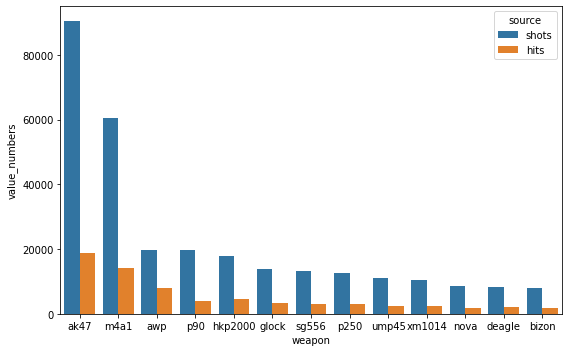

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 5))
g = sns.barplot(x='weapon', y="value_numbers", hue="source",
                data=test_data_melted, ax=ax1)
plt.tight_layout()
plt.show()

In [8]:
bar_chart_shots = alt.Chart(test_data_melted, title='Shots per weapon used').mark_bar().encode(
        column = alt.Column('weapon', 
                            spacing=5, 
                            sort=['value_numbers'],
                            header = alt.Header(labelOrient="bottom", titleOrient='bottom', titleColor='green', titleFontSize=20)), 
        x=alt.X('source', sort=['value_numbers'], axis=None),
        y=alt.Y('value_numbers:Q', title=''),
        color=alt.Color('source', scale=alt.Scale(range=['#f63366', '#4c78a8']))
    ).configure_axis(labelFontSize=12, titleFontSize=16).configure_title(fontSize=20).configure_view(stroke='transparent')

# bar_chart_shots.display()

In [10]:
singular_df = test_data_melted_2[test_data_melted_2['weapon'] == 'ak47']

bar_chart_weapon = alt.Chart(singular_df, title='Shots per weapon').mark_bar().encode(
        column = alt.Column('weapon', 
                            spacing=5, 
                            sort=['value_numbers'],
                            header = alt.Header(labelOrient="bottom", titleOrient='bottom', titleFontSize=20)), 
        x=alt.X('source', sort=['value_numbers'], axis=None),
        y=alt.Y('value_numbers:Q', title=''),
        color=alt.Color('source', scale=alt.Scale(range=['#31333f', '#f63366', '#4c78a8']))
    ).configure_axis(labelFontSize=12, titleFontSize=16).configure_title(fontSize=20).configure_view(stroke='transparent')

bar_chart_weapon.display()

alt.Chart(...)

In [11]:
singular_df.head()

,weapon,source,value_numbers
0,ak47,shots,90494
11,ak47,hits,18889
22,ak47,kills,5310


In [12]:
bar_chart_weapon = alt.Chart(singular_df, title='Shots vs Hits').mark_bar(opacity=0.7).encode(
        x=alt.X('weapon', sort=['value_numbers'], axis=alt.Axis(grid=False, title=None)),
        y=alt.Y('value_numbers', axis=alt.Axis(grid=True, title=None), stack=None),
        color=alt.Color('source', scale=alt.Scale(range=['#f63366', '#4c78a8']))
    )

text = bar_chart_weapon.mark_text(baseline='bottom', align='center').encode(text='value_numbers')

tmp_chart = alt.layer(bar_chart_weapon, text).configure_axis(labelFontSize=12, titleFontSize=16).configure_title(fontSize=20).configure_view(stroke='transparent').configure_legend(orient='bottom')

bar_chart_weapon.display()

alt.Chart(...)

In [13]:
_, _, headshots = get_ordered_numbers(r, 'headshot')
print(headshots)

{'headshot': 7231}


In [17]:
_, _, damage = get_ordered_numbers(r, 'damage', truncate_name=False)
print(damage)

_, _, rounds = get_ordered_numbers(r, 'total_rounds_played', truncate_name=False)
print(rounds)

adr = damage['total_damage_done'] / rounds['total_rounds_played']

print(f"{adr:.05f}")

{'total_damage_done': 3714396, 'last_match_damage': 5660}
{'total_rounds_played': 15717}
236.32983


In [18]:
_, _, streak = get_ordered_numbers(r, 'streak', ignore_terms)

print(streak)

ValueError: not enough values to unpack (expected 2, got 0)

In [25]:
_, _, rounds = get_ordered_numbers(r, 'last_match_rounds', truncate_name=False)
print(rounds['last_match_rounds'])
print(damage['last_match_damage'])

1
5660


In [34]:
_, _, kills_ratio = get_ordered_numbers(r, 'kills', truncate_name=False)
_, _, deaths_ratio = get_ordered_numbers(r, 'deaths', truncate_name=False)

KD_ratio = kills_ratio['total_kills'] / deaths_ratio['total_deaths']

KD_ratio

1.0548023991455098

In [14]:
_, lm_k_val, lm_k = get_ordered_numbers(r, 'last_match_kills', truncate_name=False)
_, lm_d_val, lm_d = get_ordered_numbers(r, 'last_match_deaths', truncate_name=False)

lm_k_val[0] / lm_d_val[0]

3.4615384615384617